In [1]:
import tensorflow as tf
import yfinance as yf
from transformers import pipeline
from collections import Counter
import numpy as np
import pandas as pd

c:\a\envs\env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import yfinance as yf

nifty50_tickers = ["TCS.NS", "RELIANCE.NS", "INFY.NS", "HDFCBANK.NS"]

data = yf.download(nifty50_tickers, start="2020-01-01", end="2025-02-17", interval="1d")

data.to_csv("nifty50_stock_data.csv")
print(data.columns)

[*********************100%%**********************]  4 of 4 completed
MultiIndex([('Adj Close', 'HDFCBANK.NS'),
            ('Adj Close',     'INFY.NS'),
            ('Adj Close', 'RELIANCE.NS'),
            ('Adj Close',      'TCS.NS'),
            (    'Close', 'HDFCBANK.NS'),
            (    'Close',     'INFY.NS'),
            (    'Close', 'RELIANCE.NS'),
            (    'Close',      'TCS.NS'),
            (     'High', 'HDFCBANK.NS'),
            (     'High',     'INFY.NS'),
            (     'High', 'RELIANCE.NS'),
            (     'High',      'TCS.NS'),
            (      'Low', 'HDFCBANK.NS'),
            (      'Low',     'INFY.NS'),
            (      'Low', 'RELIANCE.NS'),
            (      'Low',      'TCS.NS'),
            (     'Open', 'HDFCBANK.NS'),
            (     'Open',     'INFY.NS'),
            (     'Open', 'RELIANCE.NS'),
            (     'Open',      'TCS.NS'),
            (   'Volume', 'HDFCBANK.NS'),
            (   'Volume',     'INFY.NS'),
       

In [3]:
data.tail()

Adj Close                                               Close  \
            HDFCBANK.NS      INFY.NS  RELIANCE.NS       TCS.NS  HDFCBANK.NS   
Date                                                                          
2025-02-10  1715.750000  1880.300049  1253.650024  4036.949951  1715.750000   
2025-02-11  1701.400024  1875.650024  1234.849976  3963.550049  1701.400024   
2025-02-12  1706.800049  1863.150024  1216.550049  3950.149902  1706.800049   
2025-02-13  1697.699951  1843.250000  1216.099976  3910.149902  1697.699951   
2025-02-14  1694.849976  1856.400024  1217.250000  3934.850098  1694.849976   

                                                          High               \
                INFY.NS  RELIANCE.NS       TCS.NS  HDFCBANK.NS      INFY.NS   
Date                                                                          
2025-02-10  1880.300049  1253.650024  4036.949951  1723.449951  1905.000000   
2025-02-11  1875.650024  1234.849976  3963.550049  1711.000000  1903.000000   
2025-02-12  1863.150024  1216.550049  3950.149902  1712.000000  1894.599976   
2025-02-13  1843.250000  1216.099976  3910.149902  1714.250000  1873.500000   
2025-02-14  1856.400024  1217.250000  3934.850098  1701.900024  1859.300049   

            ...          Low                      Open               \
            ...  RELIANCE.NS       TCS.NS  HDFCBANK.NS      INFY.NS   
Date        ...                                                       
2025-02-10  ...  1245.550049  4014.350098  1717.300049  1905.000000   
2025-02-11  ...  1230.099976  3955.000000  1703.000000  1883.099976   
2025-02-12  ...  1193.349976  3940.149902  1693.000000  1885.000000   
2025-02-13  ...  1212.000000  3902.250000  1699.000000  1868.500000   
2025-02-14  ...  1205.449951  3900.000000  1701.900024  1854.000000   

                                          Volume                                
            RELIANCE.NS       TCS.NS HDFCBANK.NS  INFY.NS RELIANCE.NS   TCS.NS  
Date                                                                            
2025-02-10  1264.500000  4040.000000   8597975.0  3828734     6970972  1339511  
2025-02-11  1264.550049  4018.399902  11362352.0  4411601     8859714  1810908  
2025-02-12  1219.449951  3971.100098  11404785.0  5633947    21131654  1678002  
2025-02-13  1217.050049  3968.000000   6301217.0  5237744     8511216  2277310  
2025-02-14  1219.000000  3925.000000   9979946.0  5292961    10298145  1681975  

[5 rows x 24 columns]

In [2]:
import requests

def fetch_news(stock_name):
    api_key = "ad879839b920406d9651285fc34616e7"
    url = f"https://newsapi.org/v2/everything?q={stock_name}&language=en&sortBy=publishedAt&apiKey={api_key}"
    
    response = requests.get(url)
    data = response.json()
    
    articles = data.get("articles", [])
    headlines = [article["title"] + " " + article["description"] for article in articles]
    
    return headlines


stock_name = "Cochin Shipyard"
news_headlines = fetch_news(stock_name)
print(news_headlines)

["Cochin Shipyard signs MoU with Maersk amid India's ₹25,000 crore shipbuilding fund plan Cochin Shipyard signed a MoU with the second-largest shipping giant, Maersk, to conduct ship repair, maintenance and shipbuilding in India, according to a BSE filing. Shares of the PSU firm has given investors over 600% returns in the last five years.", 'Maersk, Cochin Shipyard ink MoU to explore ship repairs, shipbuilding activities Under the MoU, Maersk will leverage its expertise as an off-taker in its global fleet to strengthen CSL’s capabilities, primarily focusing on container ship maintenance, repair, and dry-docking operations', 'Maersk, Cochin Shipyard ink MoU to explore ship repairs, shipbuilding activities Under the MoU, Maersk will leverage its expertise as an off-taker in its global fleet to strengthen CSL’s capabilities, primarily focusing on container ship maintenance, repair, and dry-docking operations', 'Stock Market Highlights 17 February 2025: Sensex, Nifty crawl up to close mar

In [3]:
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

def get_sentiment_scores(news_list):
    scores = [sentiment_pipeline(news) for news in news_list]
    return scores

sentiment_scores = get_sentiment_scores(news_headlines)
print(sentiment_scores)


[[{'label': 'positive', 'score': 0.9405520558357239}], [{'label': 'positive', 'score': 0.8918868899345398}], [{'label': 'positive', 'score': 0.8918868899345398}], [{'label': 'positive', 'score': 0.930934727191925}], [{'label': 'negative', 'score': 0.9643874764442444}], [{'label': 'neutral', 'score': 0.9316685795783997}], [{'label': 'positive', 'score': 0.5673838257789612}], [{'label': 'positive', 'score': 0.7629152536392212}], [{'label': 'neutral', 'score': 0.9346480369567871}], [{'label': 'neutral', 'score': 0.8421849608421326}], [{'label': 'negative', 'score': 0.5586294531822205}], [{'label': 'neutral', 'score': 0.9407637715339661}], [{'label': 'positive', 'score': 0.52093106508255}], [{'label': 'negative', 'score': 0.9702807664871216}], [{'label': 'negative', 'score': 0.9752031564712524}], [{'label': 'negative', 'score': 0.9755972027778625}], [{'label': 'positive', 'score': 0.6624003052711487}], [{'label': 'positive', 'score': 0.9471021890640259}], [{'label': 'negative', 'score': 0.

In [4]:
flat_labels = [item[0] for item in sentiment_scores]

sentiment_counts = Counter([entry['label'] for entry in flat_labels])

sentiment_scores = {}
for sentiment in ['positive', 'neutral', 'negative']:
    scores = [entry['score'] for entry in flat_labels if entry['label'] == sentiment]
    sentiment_scores[sentiment] = np.mean(scores) if scores else 0

overall_sentiment = max(sentiment_counts, key=sentiment_counts.get)

print("Sentiment Counts:", sentiment_counts)
print("Average Confidence Scores:", sentiment_scores)
print("Overall Sentiment:", overall_sentiment)

Sentiment Counts: Counter({'positive': 16, 'negative': 13, 'neutral': 8})
Average Confidence Scores: {'positive': 0.8350736424326897, 'neutral': 0.8238292410969734, 'negative': 0.9371603635641245}
Overall Sentiment: positive


In [7]:
data = pd.read_csv(r"C:\Projects\Indian-Stock-Predictor\exp\nifty50_stock_data.csv")
data.head(5)

,Unnamed: 0,Adj Close,Adj Close.1,Adj Close.2,Adj Close.3,Close,Close.1,Close.2,Close.3,High,...,Low.2,Low.3,Open,Open.1,Open.2,Open.3,Volume,Volume.1,Volume.2,Volume.3
0,NaN,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS,HDFCBANK.NS,...,RELIANCE.NS,TCS.NS,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,1227.4285888671875,655.6152954101562,671.07421875,1975.3426513671875,1278.5999755859375,736.8499755859375,690.1383056640625,2167.60009765625,1280.0,...,688.2639770507812,2154.0,1276.0999755859375,735.0,693.978515625,2168.0,1836849.0,2112415,14004468,1354908
3,2020-01-02,1235.25244140625,653.702392578125,682.4988403320312,1966.275390625,1286.75,734.7000122070312,701.8875122070312,2157.64990234375,1288.0,...,691.2355346679688,2149.199951171875,1279.0,738.9000244140625,691.2355346679688,2179.949951171875,3068583.0,5658200,17710316,2380752
4,2020-01-03,1217.6368408203125,663.756591796875,683.3212890625,2005.4613037109375,1268.4000244140625,746.0,702.7332763671875,2200.64990234375,1285.0,...,696.2643432617188,2164.0,1282.199951171875,733.9000244140625,700.8359985351562,2164.0,5427775.0,7882938,20984698,4655761


In [8]:
data = pd.read_csv(r"C:\Projects\Indian-Stock-Predictor\exp\nifty50_stock_data.csv")
data

,Unnamed: 0,Adj Close,Adj Close.1,Adj Close.2,Adj Close.3,Close,Close.1,Close.2,Close.3,High,...,Low.2,Low.3,Open,Open.1,Open.2,Open.3,Volume,Volume.1,Volume.2,Volume.3
0,NaN,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS,HDFCBANK.NS,...,RELIANCE.NS,TCS.NS,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,1227.4285888671875,655.6152954101562,671.07421875,1975.3426513671875,1278.5999755859375,736.8499755859375,690.1383056640625,2167.60009765625,1280.0,...,688.2639770507812,2154.0,1276.0999755859375,735.0,693.978515625,2168.0,1836849.0,2112415,14004468,1354908
3,2020-01-02,1235.25244140625,653.702392578125,682.4988403320312,1966.275390625,1286.75,734.7000122070312,701.8875122070312,2157.64990234375,1288.0,...,691.2355346679688,2149.199951171875,1279.0,738.9000244140625,691.2355346679688,2179.949951171875,3068583.0,5658200,17710316,2380752
4,2020-01-03,1217.6368408203125,663.756591796875,683.3212890625,2005.4613037109375,1268.4000244140625,746.0,702.7332763671875,2200.64990234375,1285.0,...,696.2643432617188,2164.0,1282.199951171875,733.9000244140625,700.8359985351562,2164.0,5427775.0,7882938,20984698,4655761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,2025-02-10,1715.75,1880.300048828125,1253.6500244140625,4036.949951171875,1715.75,1880.300048828125,1253.6500244140625,4036.949951171875,1723.449951171875,...,1245.550048828125,4014.35009765625,1717.300048828125,1905.0,1264.5,4040.0,8597975.0,3828734,6970972,1339511
1270,2025-02-11,1701.4000244140625,1875.6500244140625,1234.8499755859375,3963.550048828125,1701.4000244140625,1875.6500244140625,1234.8499755859375,3963.550048828125,1711.0,...,1230.0999755859375,3955.0,1703.0,1883.0999755859375,1264.550048828125,4018.39990234375,11362352.0,4411601,8859714,1810908
1271,2025-02-12,1706.800048828125,1863.1500244140625,1216.550048828125,3950.14990234375,1706.800048828125,1863.1500244140625,1216.550048828125,3950.14990234375,1712.0,...,1193.3499755859375,3940.14990234375,1693.0,1885.0,1219.449951171875,3971.10009765625,11404785.0,5633947,21131654,1678002
1272,2025-02-13,1697.699951171875,1843.25,1216.0999755859375,3910.14990234375,1697.699951171875,1843.25,1216.0999755859375,3910.14990234375,1714.25,...,1212.0,3902.25,1699.0,1868.5,1217.050048828125,3968.0,6301217.0,5237744,8511216,2277310


In [9]:
import pandas as pd

# Load data and use the second row as the header
data_nf = pd.read_csv(r"C:\Projects\Indian-Stock-Predictor\exp\nifty50_stock_data.csv", header=1)

# Remove any unnamed columns that are irrelevant
data_nf = data_nf.loc[:, ~data_nf.columns.str.contains('^Unnamed')]

data.drop(index=0, inplace=True)
# Print the cleaned data to verify the results
data.head()


,Unnamed: 0,Adj Close,Adj Close.1,Adj Close.2,Adj Close.3,Close,Close.1,Close.2,Close.3,High,...,Low.2,Low.3,Open,Open.1,Open.2,Open.3,Volume,Volume.1,Volume.2,Volume.3
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,1227.4285888671875,655.6152954101562,671.07421875,1975.3426513671875,1278.5999755859375,736.8499755859375,690.1383056640625,2167.60009765625,1280.0,...,688.2639770507812,2154.0,1276.0999755859375,735.0,693.978515625,2168.0,1836849.0,2112415,14004468,1354908
3,2020-01-02,1235.25244140625,653.702392578125,682.4988403320312,1966.275390625,1286.75,734.7000122070312,701.8875122070312,2157.64990234375,1288.0,...,691.2355346679688,2149.199951171875,1279.0,738.9000244140625,691.2355346679688,2179.949951171875,3068583.0,5658200,17710316,2380752
4,2020-01-03,1217.6368408203125,663.756591796875,683.3212890625,2005.4613037109375,1268.4000244140625,746.0,702.7332763671875,2200.64990234375,1285.0,...,696.2643432617188,2164.0,1282.199951171875,733.9000244140625,700.8359985351562,2164.0,5427775.0,7882938,20984698,4655761
5,2020-01-06,1191.2855224609375,657.3948974609375,667.4735107421875,2005.279296875,1240.949951171875,738.8499755859375,686.435302734375,2200.449951171875,1261.800048828125,...,684.835205078125,2187.89990234375,1260.0,746.0999755859375,694.8928833007812,2205.0,5445093.0,6519403,24519177,3023209


In [10]:
import pandas as pd

# Load data, skipping the first row and using the second row for the header
data = pd.read_csv(r"C:\Projects\Indian-Stock-Predictor\exp\nifty50_stock_data.csv", header=2)

# Remove any unnamed columns that are irrelevant
data_date = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Rename the first column explicitly to 'Date'
data_date.rename(columns={data.columns[0]: 'Date'}, inplace=True)

# Print the cleaned data to verify the results
print(data_date.head(5))


         Date
0  2020-01-01
1  2020-01-02
2  2020-01-03
3  2020-01-06
4  2020-01-07


C:\Users\aashutosh kumar\AppData\Local\Temp\ipykernel_10976\3234530719.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_date.rename(columns={data.columns[0]: 'Date'}, inplace=True)


In [11]:
result = pd.concat([data_date, data_nf], axis=1)
result.drop(index=0, inplace=True)
result.head(5)

,Date,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS,HDFCBANK.NS.1,INFY.NS.1,RELIANCE.NS.1,TCS.NS.1,HDFCBANK.NS.2,...,RELIANCE.NS.3,TCS.NS.3,HDFCBANK.NS.4,INFY.NS.4,RELIANCE.NS.4,TCS.NS.4,HDFCBANK.NS.5,INFY.NS.5,RELIANCE.NS.5,TCS.NS.5
1,2020-01-02,1227.428589,655.615295,671.074219,1975.342651,1278.599976,736.849976,690.138306,2167.600098,1280.000000,...,688.263977,2154.000000,1276.099976,735.000000,693.978516,2168.000000,1836849.0,2112415.0,14004468.0,1354908.0
2,2020-01-03,1235.252441,653.702393,682.498840,1966.275391,1286.750000,734.700012,701.887512,2157.649902,1288.000000,...,691.235535,2149.199951,1279.000000,738.900024,691.235535,2179.949951,3068583.0,5658200.0,17710316.0,2380752.0
3,2020-01-06,1217.636841,663.756592,683.321289,2005.461304,1268.400024,746.000000,702.733276,2200.649902,1285.000000,...,696.264343,2164.000000,1282.199951,733.900024,700.835999,2164.000000,5427775.0,7882938.0,20984698.0,4655761.0
4,2020-01-07,1191.285522,657.394897,667.473511,2005.279297,1240.949951,738.849976,686.435303,2200.449951,1261.800049,...,684.835205,2187.899902,1260.000000,746.099976,694.892883,2205.000000,5445093.0,6519403.0,24519177.0,3023209.0
5,2020-01-08,1210.149048,647.651978,677.742310,2010.200195,1260.599976,727.900024,696.995850,2205.850098,1271.449951,...,691.921265,2183.800049,1258.900024,738.000000,694.435669,2200.500000,7362247.0,7899363.0,16683622.0,2429317.0


In [12]:
result = result.iloc[:, :5]
result.head(10)

,Date,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
1,2020-01-02,1227.428589,655.615295,671.074219,1975.342651
2,2020-01-03,1235.252441,653.702393,682.498840,1966.275391
3,2020-01-06,1217.636841,663.756592,683.321289,2005.461304
4,2020-01-07,1191.285522,657.394897,667.473511,2005.279297
5,2020-01-08,1210.149048,647.651978,677.742310,2010.200195
6,2020-01-09,1206.981079,639.021423,672.652405,2055.218262
7,2020-01-10,1220.516846,647.340576,688.144470,2017.946655
8,2020-01-13,1231.364380,656.772034,687.988892,2017.218018
9,2020-01-14,1234.532471,688.269409,686.233032,1996.075562
10,2020-01-15,1237.892334,690.137756,679.876099,2011.157104


In [13]:
result.shape

(1272, 5)

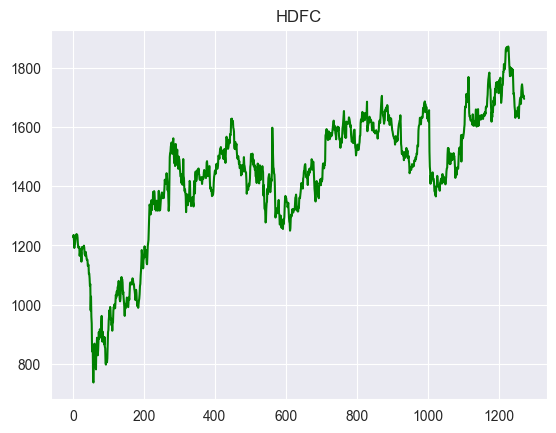

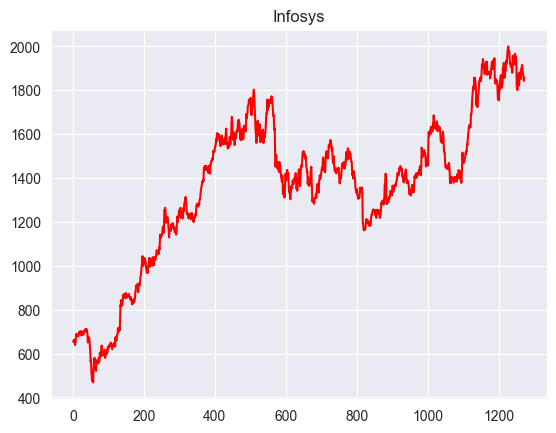

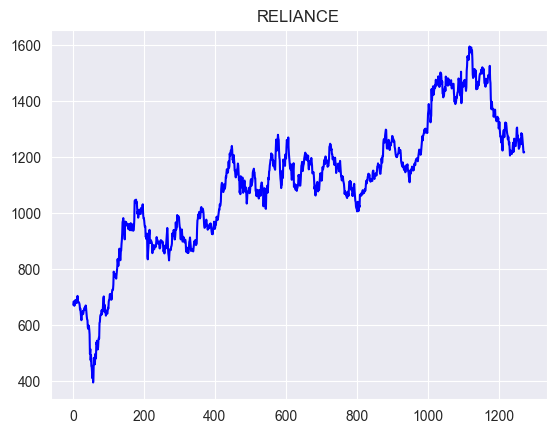

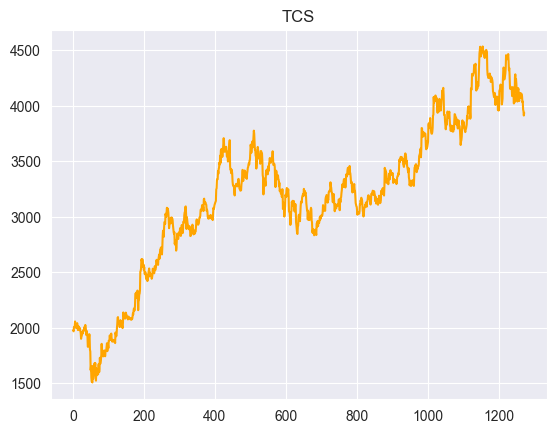

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.plot(result['HDFCBANK.NS'], color="green")
plt.title("HDFC")
plt.show()

sns.set_style("darkgrid")
plt.plot(result['INFY.NS'], color="red")
plt.title("Infosys")
plt.show()

sns.set_style("darkgrid")
plt.plot(result['RELIANCE.NS'], color="blue")
plt.title("RELIANCE")
plt.show()

sns.set_style("darkgrid")
plt.plot(result['TCS.NS'], color="orange")
plt.title("TCS")
plt.show()

In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from transformers import pipeline
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [118]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(result.drop(columns=["Date"]))

In [119]:
result['Date'] = pd.to_datetime(result['Date'])
result.dropna(inplace=True)
result.head()

,Date,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
1,2020-01-02,1227.428589,655.615295,671.074219,1975.342651
2,2020-01-03,1235.252441,653.702393,682.498840,1966.275391
3,2020-01-06,1217.636841,663.756592,683.321289,2005.461304
4,2020-01-07,1191.285522,657.394897,667.473511,2005.279297
5,2020-01-08,1210.149048,647.651978,677.742310,2010.200195


In [120]:
X = scaled_data
y = result['HDFCBANK.NS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1)) 


model.compile(optimizer='adam', loss='mean_squared_error')


X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [127]:
h = model.fit(X_train_reshaped, y_train, epochs=2000, batch_size=32)

Epoch 1/2000
32/32 [==============================] - 0s 6ms/step - loss: 10784.2402
Epoch 2/2000
32/32 [==============================] - 0s 6ms/step - loss: 10448.2764
Epoch 3/2000
32/32 [==============================] - 0s 6ms/step - loss: 9694.3096
Epoch 4/2000
32/32 [==============================] - 0s 6ms/step - loss: 9884.2852
Epoch 5/2000
32/32 [==============================] - 0s 6ms/step - loss: 10093.0488
Epoch 6/2000
32/32 [==============================] - 0s 6ms/step - loss: 10720.6113
Epoch 7/2000
32/32 [==============================] - 0s 6ms/step - loss: 9920.9707
Epoch 8/2000
32/32 [==============================] - 0s 6ms/step - loss: 11302.9053
Epoch 9/2000
32/32 [==============================] - 0s 6ms/step - loss: 10857.7344
Epoch 10/2000
32/32 [==============================] - 0s 6ms/step - loss: 9894.2188
Epoch 11/2000
32/32 [==============================] - 0s 6ms/step - loss: 10155.9141
Epoch 12/2000
32/32 [==============================] - 0s 6ms/step 

KeyboardInterrupt: 

In [17]:
import pandas as pd
import numpy as np
import requests
from collections import Counter
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [18]:
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

# Function to fetch news headlines for a stock
def fetch_news(stock_name):
    api_key = "ad879839b920406d9651285fc34616e7"  # Replace with your API key
    url = f"https://newsapi.org/v2/everything?q={stock_name}&language=en&sortBy=publishedAt&apiKey={api_key}"
    
    response = requests.get(url)
    data = response.json()
    
    articles = data.get("articles", [])
    headlines = [article["title"] + " " + article["description"] for article in articles]
    
    return headlines

# Function to analyze sentiment
def get_sentiment_scores(news_list):
    scores = [sentiment_pipeline(news) for news in news_list]
    flat_labels = [item[0] for item in scores]

    sentiment_counts = Counter([entry['label'] for entry in flat_labels])
    sentiment_scores = {}

    for sentiment in ['positive', 'neutral', 'negative']:
        scores = [entry['score'] for entry in flat_labels if entry['label'] == sentiment]
        sentiment_scores[sentiment] = np.mean(scores) if scores else 0

    overall_sentiment = max(sentiment_counts, key=sentiment_counts.get) if sentiment_counts else "neutral"
    
    return sentiment_scores, overall_sentiment


In [19]:
# Dictionary to store sentiment scores
sentiment_data = {}

# Loop through each stock in the dataset
for stock in ["HDFCBANK.NS", "INFY.NS", "RELIANCE.NS", "TCS.NS"]:  
    news_headlines = fetch_news(stock)
    
    if news_headlines:  # Check if news exists
        scores, overall = get_sentiment_scores(news_headlines)
        sentiment_data[stock] = scores
    else:
        sentiment_data[stock] = {"positive": 0, "neutral": 1, "negative": 0}  # Default if no news

# Convert sentiment dictionary to DataFrame
sentiment_df = pd.DataFrame(sentiment_data).T.reset_index()
sentiment_df.rename(columns={"index": "Stock"}, inplace=True)

# Merge sentiment data with stock data
merged_data = result.melt(id_vars=["Date"], var_name="Stock", value_name="Closing_Price")
merged_data = merged_data.merge(sentiment_df, on="Stock", how="left")

print(merged_data.head())  # Check merged dataset


         Date        Stock  Closing_Price  positive  neutral  negative
0  2020-01-02  HDFCBANK.NS    1227.428589         0        1         0
1  2020-01-03  HDFCBANK.NS    1235.252441         0        1         0
2  2020-01-06  HDFCBANK.NS    1217.636841         0        1         0
3  2020-01-07  HDFCBANK.NS    1191.285522         0        1         0
4  2020-01-08  HDFCBANK.NS    1210.149048         0        1         0


In [20]:
# Define function to create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])  # Last `seq_length` days of data
        y.append(data[i+seq_length, 0])  # Predict next day's Closing Price
    return np.array(X), np.array(y)

# Select relevant features
features = ["Closing_Price", "positive", "neutral", "negative"]
df_filtered = merged_data[features].dropna()

# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_filtered)

# Create sequences
seq_length = 10  # Using last 10 days to predict next day
X, y = create_sequences(df_scaled, seq_length)

# Split into train/test sets (80% train, 20% test)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (4061, 10, 4)
Testing Data Shape: (1016, 10, 4)


In [21]:
# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
254/254 [==============================] - 7s 13ms/step - loss: 0.0019 - val_loss: 4.9816e-04
Epoch 2/50
254/254 [==============================] - 2s 10ms/step - loss: 4.8924e-04 - val_loss: 0.0011
Epoch 3/50
254/254 [==============================] - 2s 10ms/step - loss: 3.9229e-04 - val_loss: 5.8807e-04
Epoch 4/50
254/254 [==============================] - 2s 10ms/step - loss: 3.3561e-04 - val_loss: 3.5919e-04
Epoch 5/50
254/254 [==============================] - 3s 10ms/step - loss: 3.0224e-04 - val_loss: 0.0017
Epoch 6/50
254/254 [==============================] - 3s 10ms/step - loss: 2.8780e-04 - val_loss: 4.1188e-04
Epoch 7/50
254/254 [==============================] - 2s 10ms/step - loss: 2.6665e-04 - val_loss: 3.7469e-04
Epoch 8/50
254/254 [==============================] - 2s 10ms/step - loss: 2.7170e-04 - val_loss: 2.5292e-04
Epoch 9/50
254/254 [==============================] - 2s 10ms/step - loss: 2.4964e-04 - val_loss: 6.4145e-04
Epoch 10/50
254/254 [==========

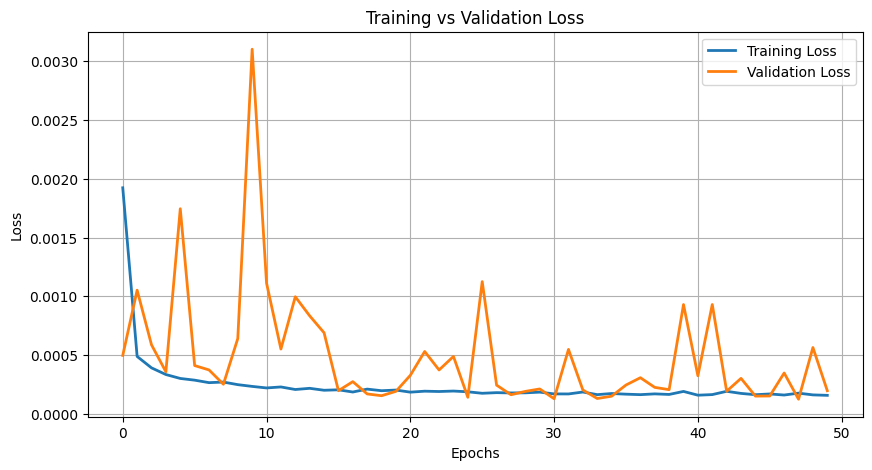

In [22]:
import matplotlib.pyplot as plt

# Assuming 'history' is your model's training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.3),  # Increased dropout
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation="relu"),
    Dense(1)  # Output layer
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

# Train model
history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=16, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

# Save model
model.save("optimized_stock_lstm.h5")


Epoch 1/100
254/254 [==============================] - 10s 19ms/step - loss: 0.0031 - val_loss: 6.3740e-04 - lr: 0.0010
Epoch 2/100
254/254 [==============================] - 3s 14ms/step - loss: 7.9289e-04 - val_loss: 8.4441e-04 - lr: 0.0010
Epoch 3/100
254/254 [==============================] - 4s 14ms/step - loss: 6.0283e-04 - val_loss: 6.6306e-04 - lr: 0.0010
Epoch 4/100
254/254 [==============================] - 4s 14ms/step - loss: 5.2202e-04 - val_loss: 6.7992e-04 - lr: 0.0010
Epoch 5/100
254/254 [==============================] - 3s 14ms/step - loss: 4.8710e-04 - val_loss: 8.8443e-04 - lr: 0.0010
Epoch 6/100
254/254 [==============================] - 3s 14ms/step - loss: 4.4387e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 7/100
254/254 [==============================] - 4s 14ms/step - loss: 4.0050e-04 - val_loss: 0.0040 - lr: 5.0000e-04
Epoch 8/100
254/254 [==============================] - 3s 14ms/step - loss: 3.8323e-04 - val_loss: 0.0037 - lr: 5.0000e-04
Epoch 9/100
254/254 [==

c:\a\envs\env2\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
